## Emmanuel Ezeobidi
#### eie0002@uah.edu

In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
# should work without error

2025-04-13 10:02:36.521859: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 10:02:38.135987: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 10:02:38.141387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-13 10:02:45.906314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import onnx
import onnxruntime as ort

# Load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the pixel values
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Expand dimensions to include channel
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Merge original train and test to resplit
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

# Convert to PyTorch tensors
#X_train_tensor = torch.FloatTensor(X_train)
#y_train_tensor = torch.LongTensor(y_train)
#X_test_tensor = torch.FloatTensor(X_test)
#y_test_tensor = torch.LongTensor(y_test)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [5]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model with a chosen optimizer and loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [7]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    # Reduce LR by 10% every 5 epochs
    return lr * 0.9 if epoch % 5 == 0 and epoch != 0 else lr

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with validation split
history = model.fit(X_train, y_train, 
                    validation_split=0.1, 
                    epochs=20, 
                    batch_size=128, 
                    callbacks=[lr_scheduler])


2025-04-13 10:04:56.816462: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 131708864 exceeds 10% of free system memory.


Epoch 1/20
329/329 [==============================] - 131s 386ms/step - loss: 0.3645 - accuracy: 0.8861 - val_loss: 0.0833 - val_accuracy: 0.9747 - lr: 0.0010
Epoch 2/20
329/329 [==============================] - 96s 290ms/step - loss: 0.1143 - accuracy: 0.9669 - val_loss: 0.0558 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 3/20
329/329 [==============================] - 100s 304ms/step - loss: 0.0856 - accuracy: 0.9735 - val_loss: 0.0466 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 4/20
329/329 [==============================] - 82s 248ms/step - loss: 0.0666 - accuracy: 0.9798 - val_loss: 0.0423 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 5/20
329/329 [==============================] - 87s 263ms/step - loss: 0.0572 - accuracy: 0.9829 - val_loss: 0.0395 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 6/20
329/329 [==============================] - 64s 195ms/step - loss: 0.0479 - accuracy: 0.9851 - val_loss: 0.0394 - val_accuracy: 0.9891 - lr: 9.0000e-04
Epoch 7/20
329/329 [==========================

In [8]:
import tf2onnx
import onnx

spec = (tf.TensorSpec(model.input.shape, tf.float32, name="input"),)

# Convert the model
model_proto, external_tensor_storage = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    output_path="mnist_model.onnx"
)

print("Model successfully converted to ONNX!")


2025-04-13 10:39:34.512730: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-04-13 10:39:34.514767: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2025-04-13 10:39:34.908176: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-04-13 10:39:34.914061: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session


Model successfully converted to ONNX!


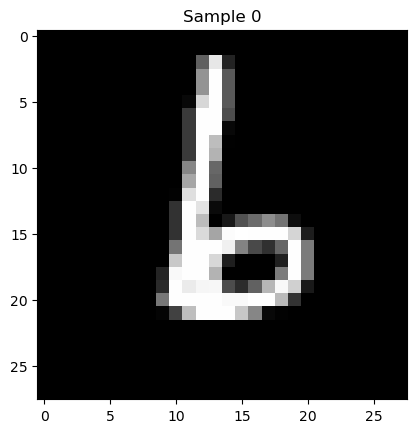

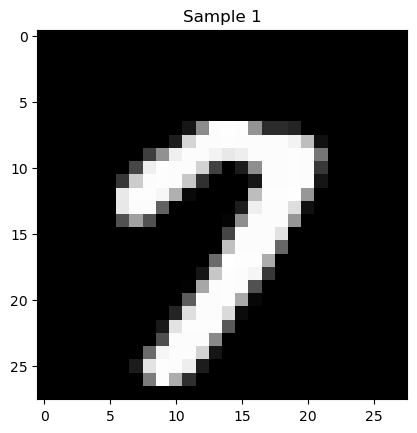

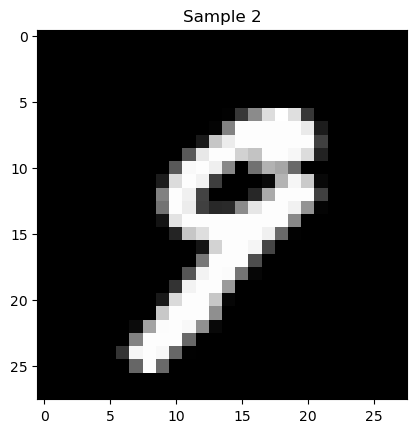

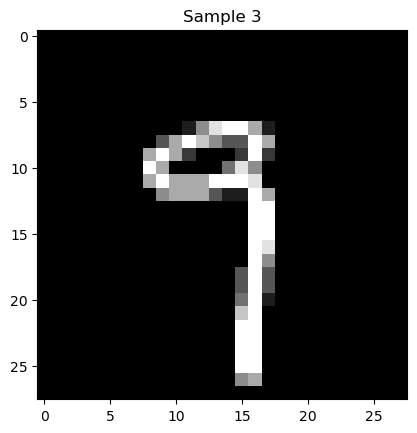

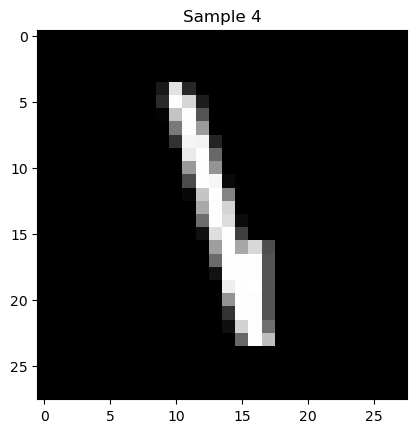

In [11]:
import matplotlib.pyplot as plt
import random

# Randomly pick 5 indices
random_indices = random.sample(range(X_test.shape[0]), 5)
samples = X_test[random_indices]

for idx, img in enumerate(samples):
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Sample {idx}")
    plt.show()


In [18]:
import onnxruntime as ort

# Load the ONNX model
session = ort.InferenceSession("mnist_model.onnx")

def predict_onnx(image):
    # Ensure image shape is (1, 28, 28, 1)
    if image.shape != (28, 28, 1):
        raise ValueError("Image must be of shape (28,28,1)")
    input_name = session.get_inputs()[0].name
    # ONNX Runtime expects float32
    image = image.astype('float32')
    # Add batch dimension: (1, 28, 28, 1)
    image = np.expand_dims(image, axis=0)
    output = session.run(None, {input_name: image})
    return output[0]

# Example: Test on one sample
predictions = predict_onnx(X_test[0])
print("Predicted probabilities:", predictions)

Predicted probabilities: [[1.0600082e-16 4.0405131e-19 1.5279669e-09 3.2999435e-14 3.4606066e-22
  1.3526391e-18 1.2667122e-20 1.5110475e-16 1.0000000e+00 7.4711138e-14]]


In [19]:
print("Sum of probabilities:", np.sum(predictions))

Sum of probabilities: 1.0


In [20]:
predicted_digit = np.argmax(predictions)
print("Predicted digit:", predicted_digit)

Predicted digit: 8


In [21]:
print("Actual digit:", y_test[0])

Actual digit: 8
